## Loading CIFAR Dataset

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

def load_pickle(f):
    return  pickle.load(f, encoding='latin1')

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'Data/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data 
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()


print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)



Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


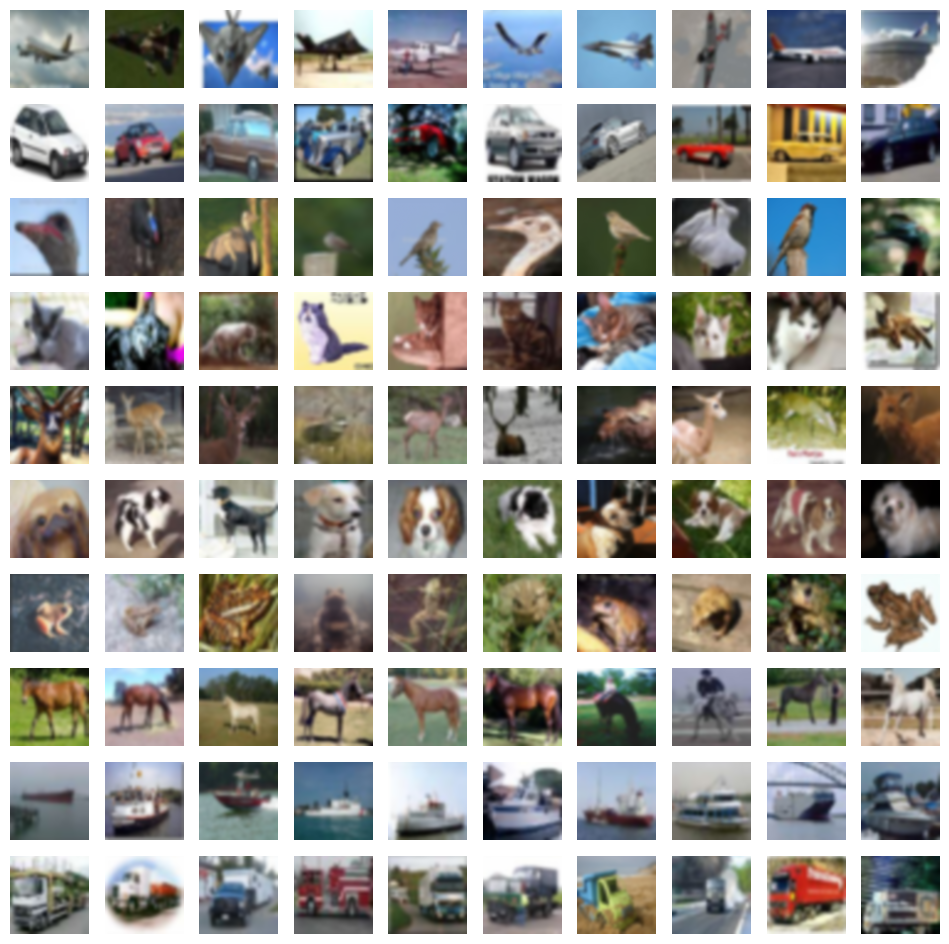

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_CIFAR(ind):
    arr = x_train[ind]
    sc_dpi = 157.35
    R = arr[0:1024].reshape(32,32)/255.0
    G = arr[1024:2048].reshape(32,32)/255.0
    B = arr[2048:].reshape(32,32)/255.0

    img = np.dstack((R,G,B))
    #title = re.sub('[!@#$b]', '', str(labels[tr_y[ind]]))
    #fig = plt.figure(figsize=(3,3))
    #ax = fig.add_subplot(111)
    #ax.imshow(img,interpolation='bicubic')
    #ax.set_title('Category = '+ title,fontsize =15)
    return img


#Classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)

# Create a figure with 10 rows and 10 columns
fig, axs = plt.subplots(10, 10, figsize=(12, 12))

for i, Y in enumerate(Classes):
    # Get indices of samples for the current class
    indices = np.where(y_train == int(Y))[0]

    # Choose 10 random samples for the current class
    random_indices = np.random.choice(indices, 10, replace=False)

    for j, idx in enumerate(random_indices):
        ax = axs[i, j]
        ax.imshow(plot_CIFAR(idx),interpolation='bicubic')
        ax.grid(False)
        ax.axis('off')

plt.show()

### Preprocessing

In [5]:

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

x_train /= 255 #This operation effectively scales down the pixel values in the image data to a range between 0 and 1
x_test /= 255
x_val /= 255

mu = np.mean(x_train, axis=0)
x_train -= mu
x_test -= mu
x_val -= mu


#from sklearn.neural_network import MLPClassifier
#model = MLPClassifier(hidden_layer_sizes=(10000,),activation= 'tanh',solver='sgd', learning_rate='adaptive', alpha=1.0, max_iter=100)
#model.fit(x_train, y_train)


#print("Train accuracy   = {:.2f}".format(model.score(x_train, y_train)))
#print("Test accuracy = {:.2f}".format(model.score(x_test, y_test)))


In [6]:
import numpy as np

def softmax(x):
    x = x - np.max(x, axis=1, keepdims=True) 
    ### This subtraction of the maximum value helps prevent numerical overflow or instability that can occur when taking the exponential of large numbers.
    ### It is a common practice to improve the numerical stability of the softmax function, 
    ## which is often used in the output layer of neural networks for multi-class classification problems.
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def softmax_loss_2(scores, y, mode='train'):
    m = scores.shape[0] #number of data
    probs = softmax(scores)
    loss = -np.sum(np.log(probs[range(m), y])) / m
    
    if mode != 'train':
        return loss
    
    # backward
    dscores = probs
    dscores[range(m), y] -= 1.0
    dscores /= m
    
    return loss, dscores

class TwoLayerNeuralNetwork:
    
    def __init__(self, num_features=784, num_hiddens=20, num_classes=10):
        self.num_hiddens = num_hiddens
        self.num_classes = num_classes
        
        # random initialization: create random weights, set all biases to zero
        self.params = {}
        self.params['W1'] = np.random.randn(num_features, num_hiddens) * 0.001
        self.params['W2'] = np.random.randn(num_hiddens,  num_classes) * 0.001
        self.params['b1'] = np.zeros((num_hiddens,))
        self.params['b2'] = np.zeros((num_classes,))
        
    def forward(self, X):
        # forward step
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        # forward step
        h_in = X @ W1 + b1       # hidden layer input
        h = np.maximum(0, h_in)  # hidden layer output (using ReLU)
        scores = h @ W2 + b2     # neural net output
        
        return scores
                            
    def train_step(self, X, y):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        # forward step
        h_in = X @ W1 + b1       # hidden layer input
        h = np.maximum(0, h_in)  # hidden layer output (using ReLU)
        scores = h @ W2 + b2     # neural net output
        
        # compute loss
        loss, dscores = softmax_loss_2(scores, y)
        
        # backward step
        db2 = dscores.sum(axis=0)
        dW2 = h.T @ dscores
        
        dh = dscores @ W2.T
        dh[h_in < 0] = 0.0
        db1 = dh.sum(axis=0)
        dW1 = X.T @ dh
        
        gradient = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
                
        return loss, gradient
        
    def train(self, X_train, y_train, X_valid, y_valid, batch_size=50, 
              alpha=0.001, lmbda=0.0001, num_epochs=20):
        
        m, n = X_train.shape        
        num_batches = m // batch_size
        
        report = "{:3d}: training loss = {:.2f} | validation loss = {:.2f}"
        
        losses = []
        for epoch in range(num_epochs):
            train_loss = 0.0
            
            for _ in range(num_batches):
                W1, b1 = self.params['W1'], self.params['b1']
                W2, b2 = self.params['W2'], self.params['b2']
                
                # select a random mini-batch
                batch_idx = np.random.choice(m, batch_size, replace=False)
                X_batch, y_batch = X_train[batch_idx], y_train[batch_idx]

                # train on mini-batch
                data_loss, gradient = self.train_step(X_batch, y_batch)
                reg_loss = 0.5 * (np.sum(W1 ** 2) + np.sum(W2 ** 2))
                train_loss += (data_loss + lmbda * reg_loss)
                losses.append(data_loss + lmbda * reg_loss)

                # regularization
                gradient['W1'] += lmbda * W1
                gradient['W2'] += lmbda * W2

                # update parameters
                for p in self.params:
                    self.params[p] = self.params[p] - alpha * gradient[p]
            
            # report training loss and validation loss
            train_loss /= num_batches
            valid_loss = softmax_loss_2(self.forward(X_valid), y_valid, mode='test')
            print(report.format(epoch + 1, train_loss, valid_loss))
        
        return losses
    
    def predict(self, X):
        """ Predict labels for input data.
        """
        scores = self.forward(X)
        return np.argmax(scores, axis=1)
    
    def predict_proba(self, X):
        """ Predict probabilties of classes for each input data.
        """
        scores = self.forward(X)
        return softmax(scores)
    

mlp = TwoLayerNeuralNetwork(num_features=3072, num_hiddens=100)
losses = mlp.train(x_train, y_train, x_val, y_val, 
                   alpha=0.1, lmbda=0.001, num_epochs=30)

  1: training loss = 1.84 | validation loss = 1.63
  2: training loss = 1.56 | validation loss = 1.51
  3: training loss = 1.47 | validation loss = 1.44
  4: training loss = 1.42 | validation loss = 1.42
  5: training loss = 1.39 | validation loss = 1.41
  6: training loss = 1.37 | validation loss = 1.38
  7: training loss = 1.34 | validation loss = 1.38
  8: training loss = 1.33 | validation loss = 1.36
  9: training loss = 1.31 | validation loss = 1.35
 10: training loss = 1.30 | validation loss = 1.36
 11: training loss = 1.29 | validation loss = 1.40
 12: training loss = 1.29 | validation loss = 1.41
 13: training loss = 1.27 | validation loss = 1.41
 14: training loss = 1.27 | validation loss = 1.35
 15: training loss = 1.27 | validation loss = 1.38
 16: training loss = 1.26 | validation loss = 1.42
 17: training loss = 1.26 | validation loss = 1.37
 18: training loss = 1.26 | validation loss = 1.39
 19: training loss = 1.25 | validation loss = 1.41
 20: training loss = 1.24 | val